<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span><ul class="toc-item"><li><span><a href="#Filter" data-toc-modified-id="Filter-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filter</a></span></li></ul></li></ul></div>

# Clustering

## Description

- Cluster funds using Spektral Clustering

## Setup

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.neighbors import kneighbors_graph

from graph_tool.all import *
import cairo

In [2]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

## Other functions

### Filter

In [3]:
def filter_data(year, verbose = False):
        
    row_info_f = row_info.copy()
    if (year != 'full'):    # If year = full take whole sample
        row_info_f = row_info_f.query('year == @year')

    begin_date = row_info_f.iloc[0,:]['report_dt']
    end_date = begin_date + pd.DateOffset(years=1) # 1 year offset
    row_info_f.reset_index(drop = True, inplace=True)

    # Filter returns
    crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
    returns_f = returns.copy()
    query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
    returns_f = returns_f.query(query)

    # Change return of month for which holdings apply to 0
    returns_f = returns_f.copy()
    mask = returns_f['report_dt'] == begin_date
    returns_f.loc[mask,'mret'] = 0
    
    # Drop all funds with first return observation after starting date
    drop_fundnos = returns_f.drop_duplicates('crsp_fundno').query('mret != 0')['crsp_fundno']
    returns_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    row_info_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    
    # Filter holdings accordingly and delet all securities with less than two observations
    holdings_f = holdings.copy()
    holdings_f = holdings[row_info_f['row']]
    
    holdings_b = sparse.csr_matrix(holdings_f, copy=True)
    holdings_b.data = np.ones(len(holdings_f.data))

    sum_sec_boolean = holdings_b.toarray().sum(0)
    col_mask = (sum_sec_boolean >= 2).flatten()

    holdings_f = holdings_f.tocsc()
    holdings_f = holdings_f[:,col_mask]
    holdings_f = holdings_f.tocsr()
    
    ## Preprocessing
    holdings_ft = normalize(holdings_f, norm = 'l1')
    
    if (verbose):
        print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))

        print('Numer of unique securities:      {:10,d}'.format(holdings_ft.shape[1]))

        print('Begin date:                      {}'.format(begin_date.date()))
        print('End date:                        {}'.format(end_date.date()))
    
    return(row_info_f, returns_f, holdings_ft, begin_date, end_date)

In [4]:
## Options

year = 2015
what = 'lipper_class'
n_neighbors = 10
size = 100

row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(year)
size = holdings_ft.shape[0]

raw_data = holdings_ft[0:size]

graph_data = kneighbors_graph(raw_data, 
                              n_neighbors = n_neighbors,
                              mode = 'distance',
                              p = 1)

In [5]:
le = LabelEncoder()
row_info_f.loc[:,'encoded'] = le.fit_transform(row_info_f[what])

cluster = row_info_f.loc[:size,'encoded']
cluster_text = row_info_f.loc[:size,what]

distance = graph_data.data
vertex_n = graph_data.shape[0]

x, y = graph_data.nonzero()

g = Graph(directed=False)
g.add_vertex(vertex_n)

for s , t in zip(x,y):
    g.add_edge(g.vertex(s), g.vertex(t))

cluster_text.values

v_cluster = g.new_vertex_property('int', vals = cluster)
v_text = g.new_vertex_property("string", vals = cluster_text.values)

In [6]:
e_distance = g.new_edge_property('double', vals = distance)

e_distance = prop_to_size(e_distance, mi=1, ma=10, log=False, power=0.5)

In [7]:
pos = sfdp_layout(g, eweight = e_distance)

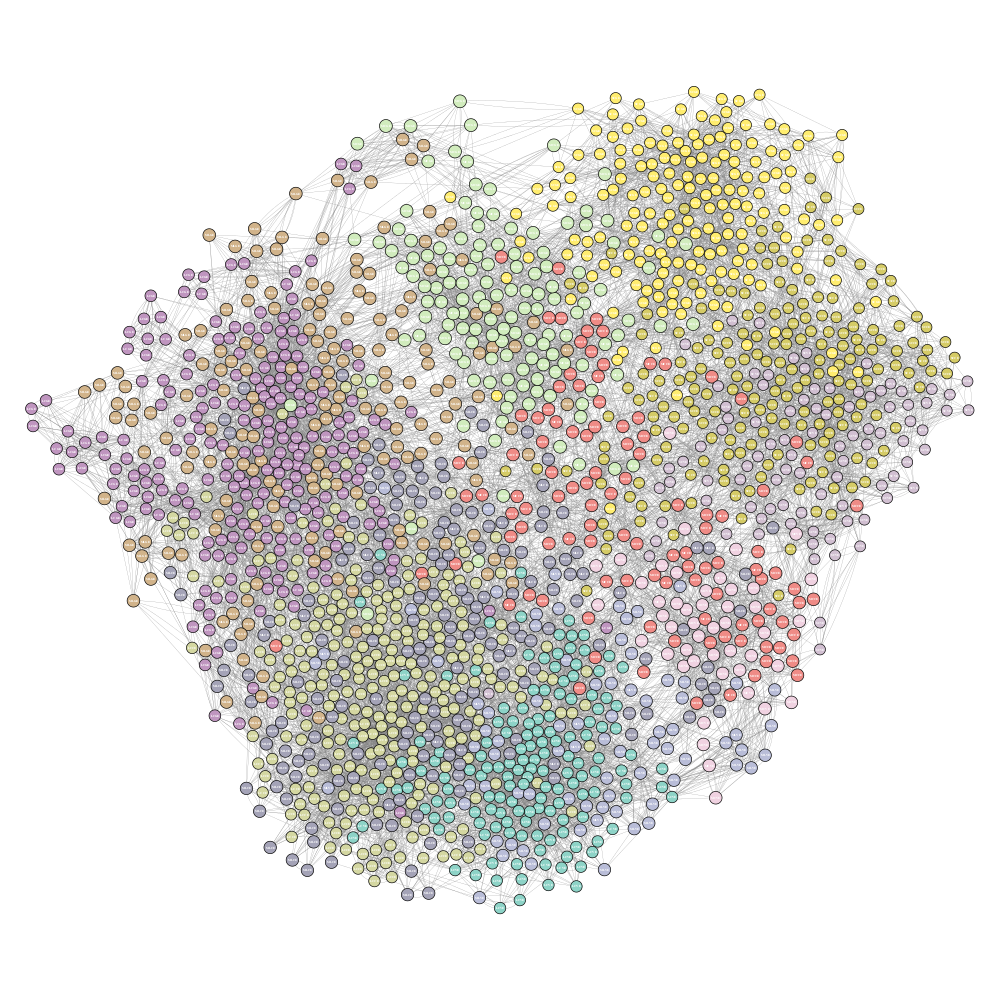

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x12f028bd0, at 0x135069e90>

In [9]:
graph_draw(g, 
           output_size = (1000,1000), 
           #output = 'test.pdf',
           vprops = {#'size' : 1,
                     'color' : 'black',
                     'fill_color' : v_cluster,
                     'text' : v_text,
                     'text_color' : 'white',
                     'font_size' : 3,
                     'font_weight' : cairo.FONT_WEIGHT_BOLD,
                     'halo' : False,
                     'halo_color' : v_cluster,
                     'halo_size' : 1
                    },
           eprops = {'pen_width' : 0.2,
                     'color' : 'grey'}
           )